In [446]:
import pandas as pd
import numpy as np
import os

In [369]:
import re
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from operator import itemgetter

In [5]:
df =  pd.read_csv("./Data/results.csv")
df["date"] = pd.to_datetime(df["date"])
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
46437,2024-03-26,Scotland,Northern Ireland,0,1,Friendly,Glasgow,Scotland,False
46438,2024-03-26,Senegal,Benin,1,0,Friendly,Amiens,France,True
46439,2024-03-26,Slovenia,Portugal,2,0,Friendly,Ljubljana,Slovenia,False
46440,2024-03-26,Spain,Brazil,3,3,Friendly,Madrid,Spain,False


In [7]:
# Checking NULL
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [9]:
# Check Data Types
df.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

In [10]:
df.sort_values("date").tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
46411,2024-03-26,Tajikistan,Saudi Arabia,1,1,FIFA World Cup qualification,Dushanbe,Tajikistan,False
46412,2024-03-26,Jordan,Pakistan,7,0,FIFA World Cup qualification,Amman,Jordan,False
46413,2024-03-26,Bahrain,Nepal,3,0,FIFA World Cup qualification,Riffa,Bahrain,False
46415,2024-03-26,Bangladesh,Palestine,0,1,FIFA World Cup qualification,Dhaka,Bangladesh,False
46441,2024-03-26,Finland,Estonia,2,1,Friendly,Helsinki,Finland,False


In [61]:
# Consider matches after 2019
df = df[(df["date"] >= "2019-01-01")].reset_index(drop=True)
df.sort_values("date").head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2019-01-02,Oman,Thailand,2,0,Friendly,Abu Dhabi,United Arab Emirates,True
1,2019-01-05,United Arab Emirates,Bahrain,1,1,AFC Asian Cup,Abu Dhabi,United Arab Emirates,False
2,2019-01-06,Thailand,India,1,4,AFC Asian Cup,Abu Dhabi,United Arab Emirates,True


In [23]:
rank = pd.read_csv("./Data/fifa_ranking-2024-04-04.csv")
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank[(rank["rank_date"] >= "2019-01-01")].reset_index(drop=True)

rank

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,211.0,San Marino,SMR,854.00,854.00,0,UEFA,2019-02-07
1,210.0,Bahamas,BAH,858.00,858.00,0,CONCACAF,2019-02-07
2,108.0,Azerbaijan,AZE,1206.00,1206.00,1,UEFA,2019-02-07
3,77.0,Uganda,UGA,1320.00,1320.00,2,CAF,2019-02-07
4,76.0,Panama,PAN,1324.00,1326.00,5,CONCACAF,2019-02-07
...,...,...,...,...,...,...,...,...
8196,140.0,Burundi,BDI,1081.63,1085.83,0,CAF,2024-04-04
8197,139.0,Kuwait,KUW,1085.46,1094.05,2,AFC,2024-04-04
8198,138.0,Malaysia,MAS,1094.54,1110.17,6,AFC,2024-04-04
8199,162.0,Tahiti,TAH,999.48,999.48,-1,OFC,2024-04-04


In [67]:
rank.query(" confederation == 'UEFA' ").head(20)

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
391852,2024-03-16,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391853,2024-03-17,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391854,2024-03-18,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391855,2024-03-19,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391856,2024-03-20,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391857,2024-03-21,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391858,2024-03-22,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391859,2024-03-23,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391860,2024-03-24,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA
391861,2024-03-25,29.0,Wales,WAL,1521.88,1521.88,0.0,UEFA


In [62]:
print(df.columns)
print(rank.columns)

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral'],
      dtype='object')
Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'confederation', 'rank_date'],
      dtype='object')


In [70]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], 
                                             group_keys=False).resample('D').first().ffill().reset_index()
rank.query(" country_full == 'Germany' ").head()

,rank_date,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation
139416,2019-02-07,16.0,Germany,GER,1558.0,1558.0,0.0,UEFA
139417,2019-02-08,16.0,Germany,GER,1558.0,1558.0,0.0,UEFA
139418,2019-02-09,16.0,Germany,GER,1558.0,1558.0,0.0,UEFA
139419,2019-02-10,16.0,Germany,GER,1558.0,1558.0,0.0,UEFA
139420,2019-02-11,16.0,Germany,GER,1558.0,1558.0,0.0,UEFA


In [71]:
df_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_ranked = df_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)
df_ranked

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2019-02-21,Kazakhstan,Moldova,1,0,Friendly,Belek,Turkey,True,1159.00,1159.00,117.0,-2.0,979.00,979.00,170.0,0.0
1,2019-02-27,Cuba,Bermuda,5,0,Friendly,Havana,Cuba,False,963.00,963.00,174.0,0.0,952.00,952.00,176.0,0.0
2,2019-03-03,Bolivia,Nicaragua,2,2,Friendly,Villa Tunari,Bolivia,False,1374.00,1374.00,60.0,1.0,1119.00,1119.00,128.0,-1.0
3,2019-03-04,Barbados,Grenada,3,0,Friendly,Kingstown,Saint Vincent and the Grenadines,True,998.00,998.00,162.0,0.0,968.00,968.00,173.0,0.0
4,2019-03-06,El Salvador,Guatemala,3,1,Friendly,Los Angeles,United States,True,1327.00,1327.00,73.0,3.0,1061.00,1061.00,149.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,2024-03-26,Scotland,Northern Ireland,0,1,Friendly,Glasgow,Scotland,False,1506.89,1506.89,34.0,-2.0,1333.17,1333.17,74.0,2.0
3821,2024-03-26,Senegal,Benin,1,0,Friendly,Amiens,France,True,1620.74,1594.31,17.0,-3.0,1225.10,1225.10,98.0,1.0
3822,2024-03-26,Slovenia,Portugal,2,0,Friendly,Ljubljana,Slovenia,False,1431.40,1427.84,55.0,1.0,1745.06,1745.06,7.0,0.0
3823,2024-03-26,Spain,Brazil,3,3,Friendly,Madrid,Spain,False,1732.64,1732.64,8.0,0.0,1784.09,1784.09,5.0,0.0


In [179]:
df_ranked[(df_ranked.home_team == "Czech Republic") | (df_ranked.away_team == "Czech Republic")]

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away


In [181]:
df_ranked.home_team.unique()

array(['Kazakhstan', 'Cuba', 'Bolivia', 'Barbados', 'El Salvador',
       'Cambodia', 'Bahamas', 'Fiji', 'Solomon Islands', 'Germany',
       'Wales', 'Kosovo', 'Kuwait', 'Mauritius', 'United Arab Emirates',
       'Northern Ireland', 'Netherlands', 'Croatia', 'Slovakia',
       'Austria', 'North Macedonia', 'Israel', 'Cyprus', 'Belgium',
       'British Virgin Islands', 'Argentina', 'Guatemala', 'Japan',
       'Mexico', 'Peru', 'Bulgaria', 'Portugal', 'Luxembourg', 'Albania',
       'Andorra', 'Moldova', 'Botswana', 'Cayman Islands', 'Sudan',
       'Malawi', 'Nigeria', 'Burkina Faso', 'Tunisia', 'Brazil',
       'Malaysia', 'Oman', 'Georgia', 'Gibraltar', 'Malta', 'Sweden',
       'Spain', 'Bosnia and Herzegovina', 'Italy', 'Liechtenstein',
       'Senegal', 'Cameroon', 'Mali', 'Ghana', 'Niger', 'Zambia',
       'Dominica', 'Guyana', 'Burundi', 'Guinea-Bissau', 'Hungary',
       'Poland', 'Slovenia', 'San Marino', 'Benin', 'Libya', 'Zimbabwe',
       'Central African Republic', 'Tan

Work with Features

In [73]:
df = df_ranked.copy()

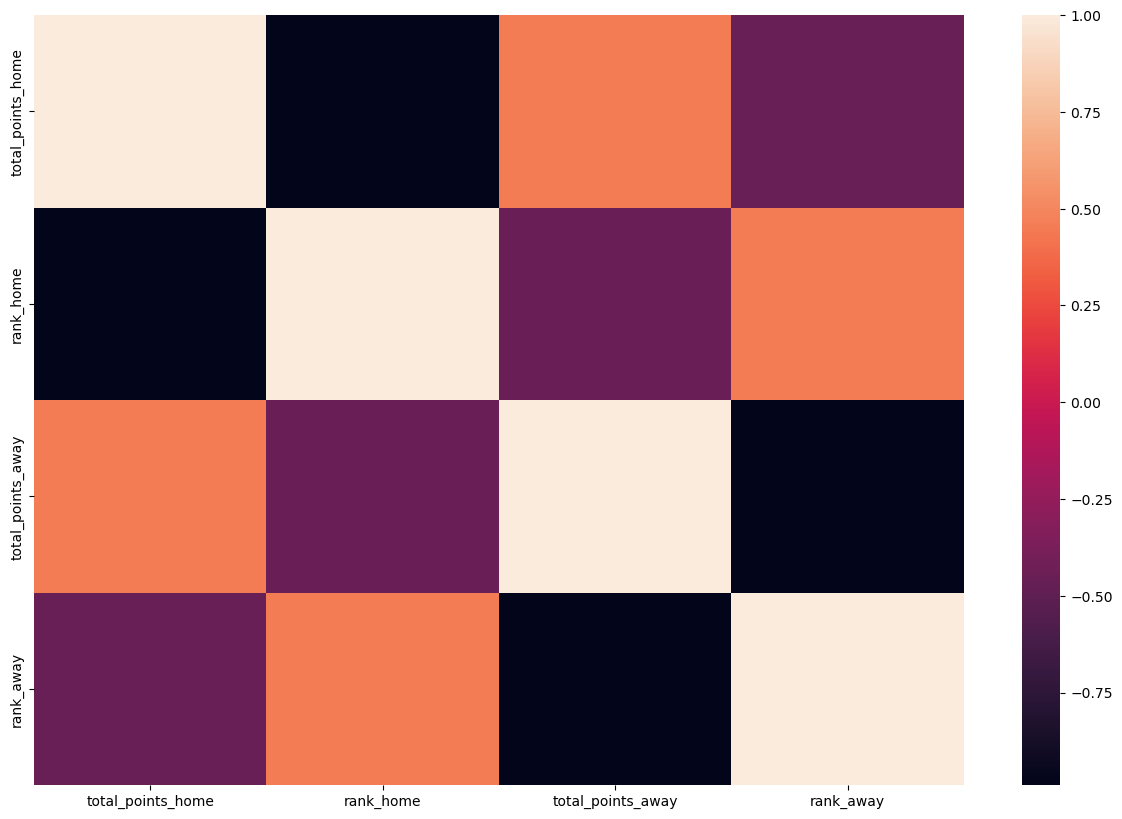

In [75]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

df[["result", "home_team_points", "away_team_points"]] = results

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

In [76]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [79]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away", "rank_change_home", 
                "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") 
                     for h in home_team.columns]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home", "rank_change_away", 
                "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") 
                     for a in away_team.columns]

In [80]:
team_stats = pd.concat([home_team, away_team])
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2019-02-21,Kazakhstan,1,0,117.0,170.0,-2.0,1159.00,0,-53.0,0.017647,3
1,2019-02-27,Cuba,5,0,174.0,176.0,0.0,963.00,0,-2.0,0.017045,3
2,2019-03-03,Bolivia,2,2,60.0,128.0,1.0,1374.00,2,-68.0,0.007812,1
3,2019-03-04,Barbados,3,0,162.0,173.0,0.0,998.00,0,-11.0,0.017341,3
4,2019-03-06,El Salvador,3,1,73.0,149.0,3.0,1327.00,0,-76.0,0.020134,3
...,...,...,...,...,...,...,...,...,...,...,...,...
3820,2024-03-26,Northern Ireland,1,0,74.0,34.0,2.0,1333.17,1,-40.0,0.088235,3
3821,2024-03-26,Benin,0,1,98.0,17.0,1.0,1225.10,0,-81.0,0.000000,0
3822,2024-03-26,Portugal,0,2,7.0,55.0,0.0,1745.06,0,48.0,0.000000,0
3823,2024-03-26,Brazil,3,3,5.0,8.0,0.0,1784.09,2,3.0,0.125000,1


In [81]:
team_stats_raw = team_stats.copy()

In [82]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [83]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)
full_df

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,...,goals_suf_mean,goals_suf_mean_l5,rank_mean,rank_mean_l5,points_mean,points_mean_l5,game_points_mean,game_points_mean_l5,game_points_rank_mean,game_points_rank_mean_l5
0,2019-02-21,Kazakhstan,1,0,117.0,170.0,-2.0,1159.00,0,-53.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,2019-02-27,Cuba,5,0,174.0,176.0,0.0,963.00,0,-2.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,2019-03-03,Bolivia,2,2,60.0,128.0,1.0,1374.00,2,-68.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,2019-03-04,Barbados,3,0,162.0,173.0,0.0,998.00,0,-11.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,2019-03-06,El Salvador,3,1,73.0,149.0,3.0,1327.00,0,-76.0,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,2024-03-26,Northern Ireland,1,0,74.0,34.0,2.0,1333.17,1,-40.0,...,1.297872,1.2,67.680851,78.4,-131.83,-0.03,1.106383,1.4,0.022078,0.038922
7646,2024-03-26,Benin,0,1,98.0,17.0,1.0,1225.10,0,-81.0,...,1.000000,1.6,93.945946,113.2,-18.11,-9.24,1.243243,0.4,0.013877,0.002920
7647,2024-03-26,Portugal,0,2,7.0,55.0,0.0,1745.06,0,48.0,...,0.660714,0.8,50.660714,80.8,131.06,16.48,2.250000,3.0,0.096203,0.057056
7648,2024-03-26,Brazil,3,3,5.0,8.0,0.0,1784.09,2,3.0,...,0.600000,1.2,30.981818,18.2,108.09,-53.52,2.072727,0.8,0.104412,0.203774


In [86]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [87]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
match_stats

,home_goals_mean,home_goals_mean_l5,home_goals_suf_mean,home_goals_suf_mean_l5,home_rank_mean,home_rank_mean_l5,home_points_mean,home_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,...,away_goals_suf_mean,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5
0,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,1.470588,1.2,1.313725,3.0,62.941176,27.2,60.89,-15.78,1.588235,0.4,...,1.297872,1.2,67.680851,78.4,-131.83,-0.03,1.106383,1.4,0.022078,0.038922
3821,1.627119,1.8,0.644068,0.2,87.559322,91.6,115.74,19.92,2.186441,2.6,...,1.000000,1.6,93.945946,113.2,-18.11,-9.24,1.243243,0.4,0.013877,0.002920
3822,1.568627,1.8,0.941176,1.0,81.274510,83.4,62.40,26.68,1.705882,2.0,...,0.660714,0.8,50.660714,80.8,131.06,16.48,2.250000,3.0,0.096203,0.057056
3823,2.241379,1.8,0.655172,0.6,45.120690,57.6,141.64,21.92,2.086207,2.4,...,0.600000,1.2,30.981818,18.2,108.09,-53.52,2.072727,0.8,0.104412,0.203774


In [88]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df.columns


Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [92]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [93]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [94]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_0,is_friendly_1,is_friendly_1
3820,2024-03-26,Scotland,Northern Ireland,34.0,74.0,0,1,1,-40.0,-2.0,...,0.040298,0.007393,1.106383,1.4,0.022078,0.038922,False,False,True,True
3821,2024-03-26,Senegal,Benin,17.0,98.0,1,0,0,-81.0,-3.0,...,0.049315,0.034018,1.243243,0.4,0.013877,0.002920,False,False,True,True
3822,2024-03-26,Slovenia,Portugal,55.0,7.0,2,0,0,48.0,1.0,...,0.029210,0.026504,2.250000,3.0,0.096203,0.057056,False,False,True,True
3823,2024-03-26,Spain,Brazil,8.0,5.0,3,3,2,3.0,0.0,...,0.091886,0.046042,2.072727,0.8,0.104412,0.203774,False,False,True,True
3824,2024-03-26,Finland,Estonia,60.0,123.0,2,1,0,-63.0,1.0,...,0.051664,0.010899,0.830189,0.2,0.008553,0.001786,False,False,True,True


In [95]:
base_df.isna().sum()

date                              0
home_team                         0
away_team                         0
rank_home                         0
rank_away                         0
home_score                        0
away_score                        0
result                            0
rank_dif                          0
rank_change_home                  0
rank_change_away                  0
home_goals_mean                  95
home_goals_mean_l5               95
home_goals_suf_mean              95
home_goals_suf_mean_l5           95
home_rank_mean                   95
home_rank_mean_l5                95
home_points_mean                  0
home_points_mean_l5               0
away_goals_mean                  98
away_goals_mean_l5               98
away_goals_suf_mean              98
away_goals_suf_mean_l5           98
away_rank_mean                   98
away_rank_mean_l5                98
away_points_mean                  0
away_points_mean_l5               0
home_game_points_mean       

In [96]:
base_df_no_fg = base_df.dropna()

In [97]:
df = base_df_no_fg.copy()

def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

df = df.copy()
df["target"] = df["result"].apply(lambda x: no_draw(x))
df

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,...,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_0,is_friendly_1,is_friendly_1,target
65,2019-03-24,Fiji,Mauritius,169.0,156.0,1,0,0,13.0,0.0,...,0.019481,3.000000,3.0,0.019481,0.019481,False,False,True,True,0
66,2019-03-24,Northern Ireland,Belarus,36.0,78.0,2,1,0,-42.0,1.0,...,0.031250,0.000000,0.0,0.000000,0.000000,True,True,False,False,0
67,2019-03-24,Netherlands,Germany,14.0,16.0,2,3,1,-2.0,0.0,...,0.038462,1.000000,1.0,0.032258,0.032258,True,True,False,False,1
68,2019-03-24,Wales,Slovakia,19.0,29.0,1,0,0,-10.0,0.0,...,0.032258,3.000000,3.0,0.057692,0.057692,True,True,False,False,0
69,2019-03-24,Hungary,Croatia,52.0,4.0,2,1,0,48.0,1.0,...,0.000000,3.000000,3.0,0.027778,0.027778,True,True,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,2024-03-26,Scotland,Northern Ireland,34.0,74.0,0,1,1,-40.0,-2.0,...,0.007393,1.106383,1.4,0.022078,0.038922,False,False,True,True,1
3821,2024-03-26,Senegal,Benin,17.0,98.0,1,0,0,-81.0,-3.0,...,0.034018,1.243243,0.4,0.013877,0.002920,False,False,True,True,0
3822,2024-03-26,Slovenia,Portugal,55.0,7.0,2,0,0,48.0,1.0,...,0.026504,2.250000,3.0,0.096203,0.057056,False,False,True,True,0
3823,2024-03-26,Spain,Brazil,8.0,5.0,3,3,2,3.0,0.0,...,0.046042,2.072727,0.8,0.104412,0.203774,False,False,True,True,1


In [98]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [99]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

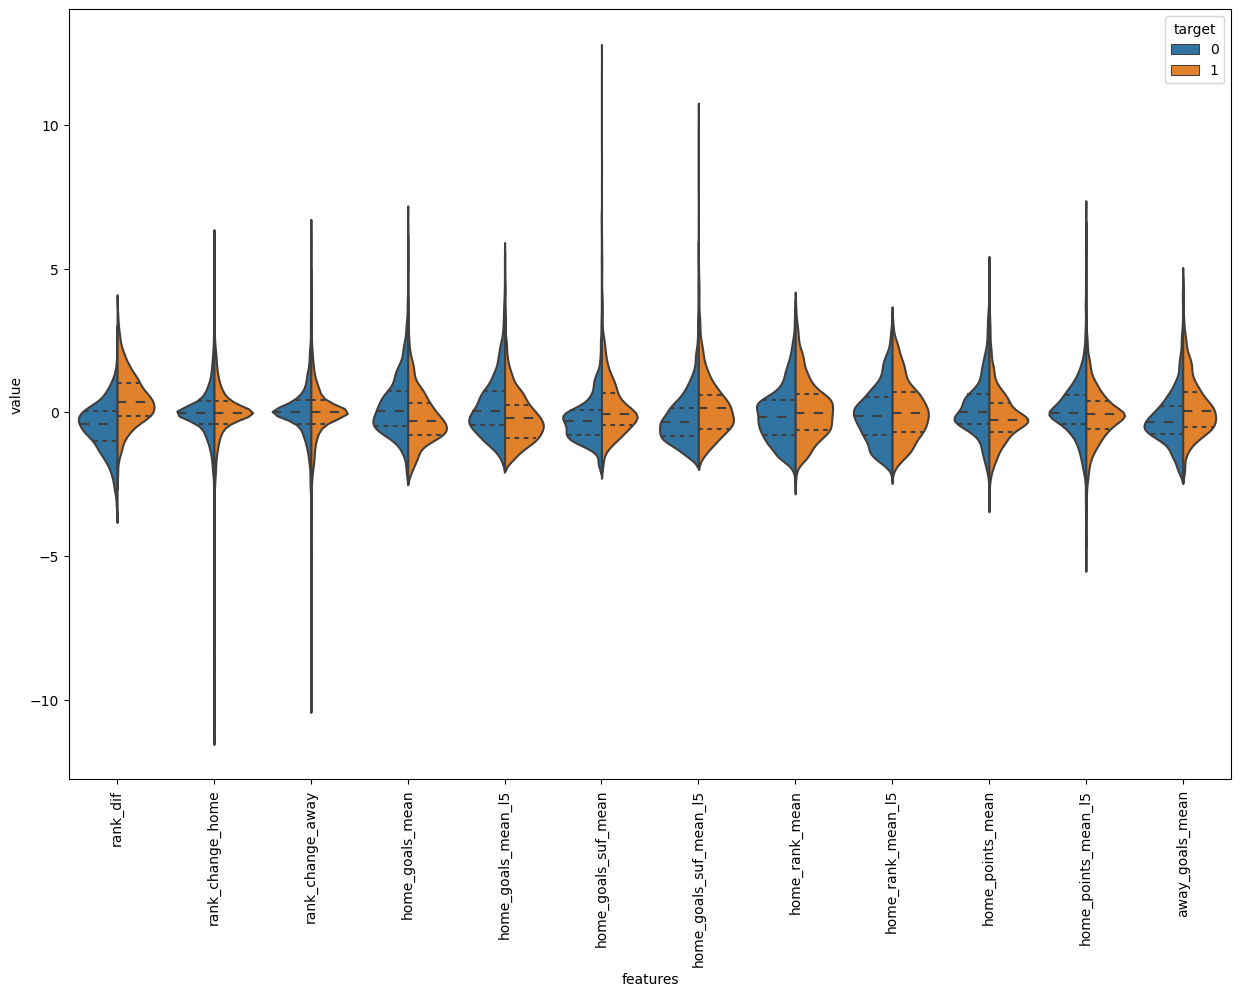

In [100]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

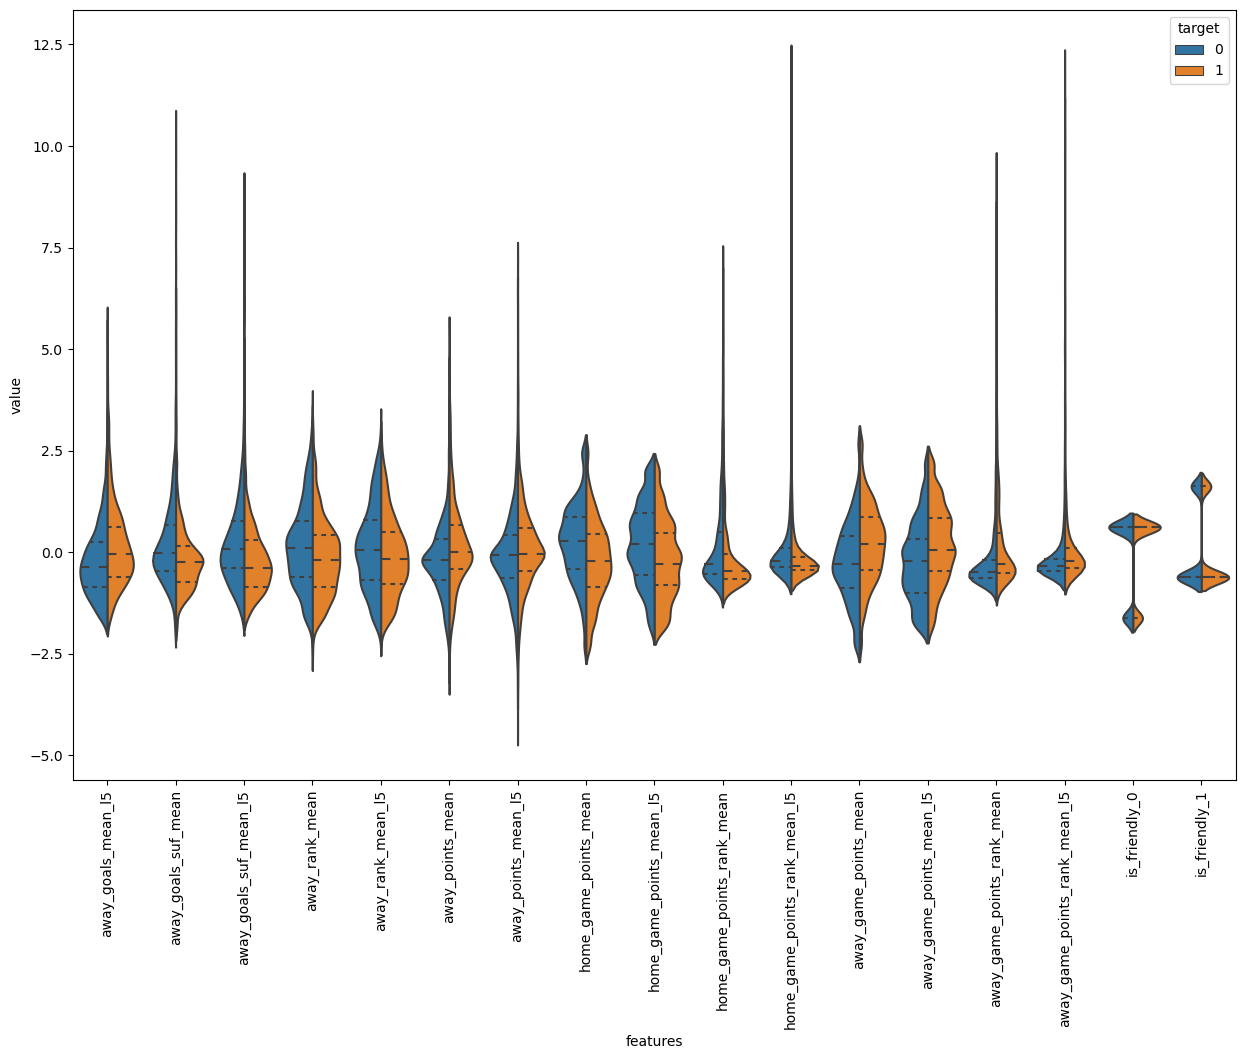

In [101]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()


In [102]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

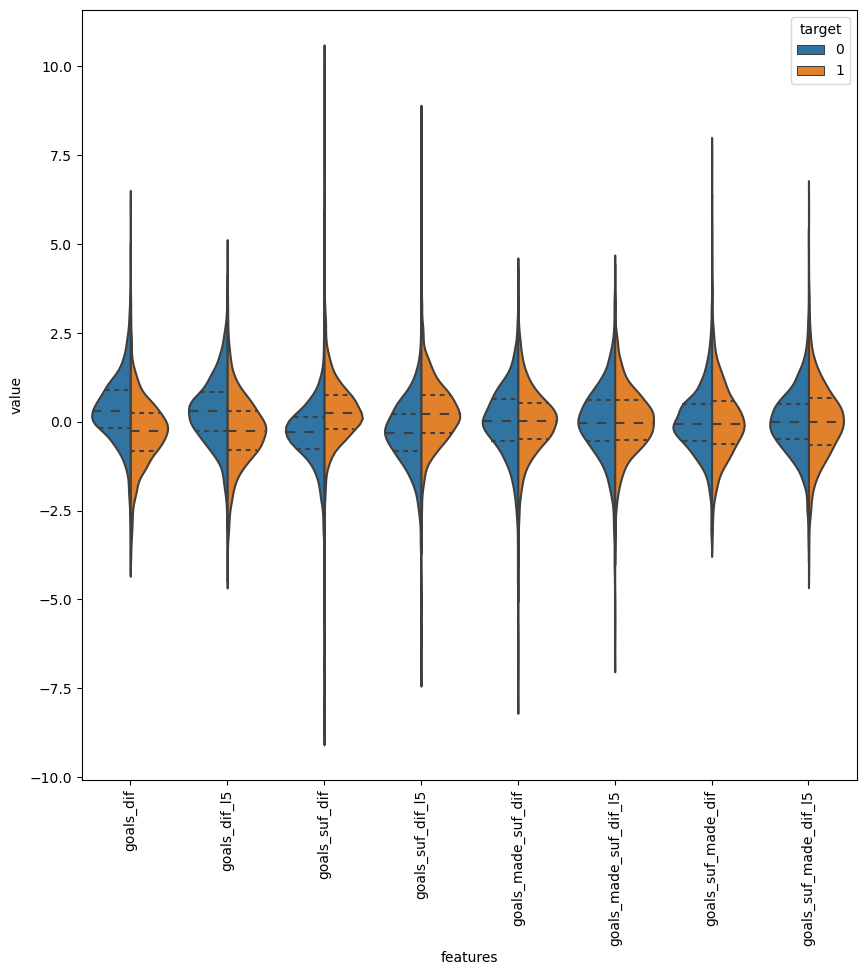

In [103]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

In [104]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

In [106]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

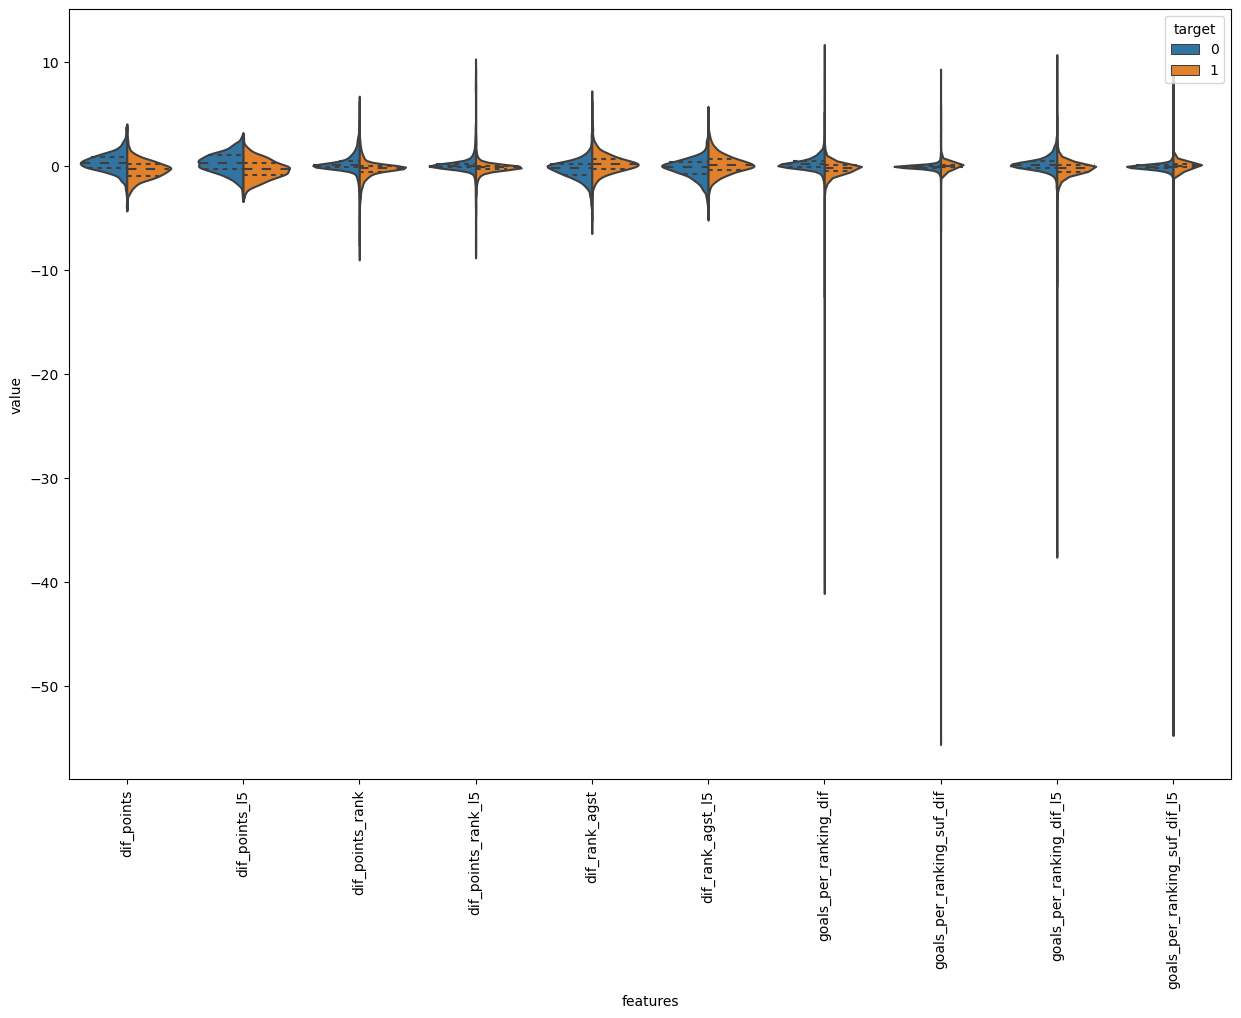

In [107]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

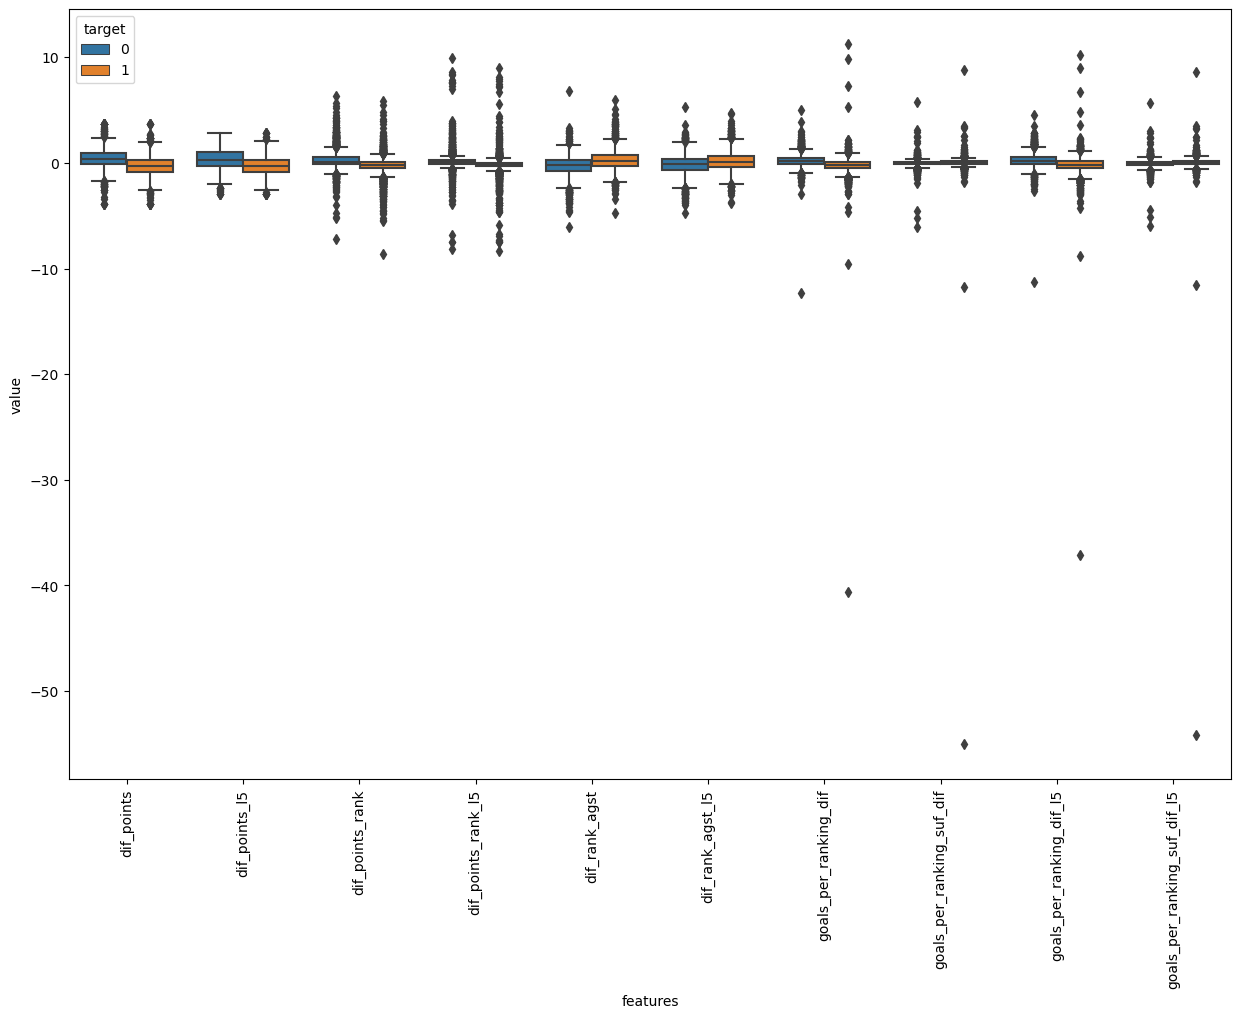

In [108]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


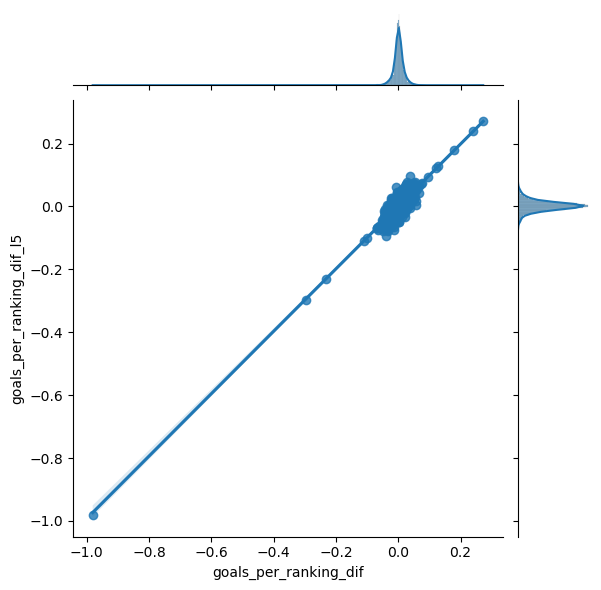

In [109]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

In [110]:
def create_db(df):
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

In [111]:
model_db = create_db(df)

In [112]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_0,is_friendly_1,is_friendly_1
65,Fiji,Mauritius,0,13.0,0.000000,0.0,-1.000000,-1.0,0.000000,0.000000,0.0,0.000000,0.000000,False,False,True,True
66,Northern Ireland,Belarus,0,-42.0,2.000000,2.0,-4.000000,-4.0,0.020833,82.000000,82.0,0.031250,0.031250,True,True,False,False
67,Netherlands,Germany,1,-2.0,3.000000,3.0,-1.000000,-1.0,0.019024,47.000000,47.0,0.006203,0.006203,True,True,False,False
68,Wales,Slovakia,0,-10.0,-1.000000,-1.0,0.000000,0.0,-0.027709,41.000000,41.0,-0.025434,-0.025434,True,True,False,False
69,Hungary,Croatia,0,48.0,-2.000000,-2.0,1.000000,1.0,-0.018519,-79.000000,-79.0,-0.027778,-0.027778,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,Scotland,Northern Ireland,1,-40.0,0.491865,0.0,0.015853,1.8,0.008904,-4.739675,-51.2,0.018221,-0.031528,False,False,True,True
3821,Senegal,Benin,0,-81.0,0.573065,0.8,-0.355932,-1.4,0.007363,-6.386624,-21.6,0.035438,0.031098,False,False,True,True
3822,Slovenia,Portugal,0,48.0,-1.020658,-1.6,0.280462,0.2,-0.031810,30.613796,2.6,-0.066993,-0.030551,False,False,True,True
3823,Spain,Brazil,1,3.0,0.277743,1.2,0.055172,-0.6,-0.013705,14.138871,39.4,-0.012527,-0.157732,False,False,True,True


In [114]:
# Train Test

In [115]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)


In [240]:
gb = GradientBoostingClassifier(random_state=6)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=6),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [241]:
gb = gb_cv.best_estimator_

In [242]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           random_state=6)

In [279]:
# params_rf = {
#     "max_depth": [10, 15, 20],  # Try shallower trees
#     "min_samples_split": [5, 10, 15],  # Increase minimum samples required to split
#     "max_leaf_nodes": [50, 100, 150, 175],  # Reduce the number of leaf nodes
#     "min_samples_leaf": [5, 10, 20],  # Increase minimum samples per leaf
#     "n_estimators": [100, 150, 200, 250],  # Reduce the number of trees
#     "max_features": ["sqrt", "log2"],  # Try different feature subsets
# }

# rf = RandomForestClassifier(random_state=3)

# rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)

# rf_cv.fit(X_train.values, np.ravel(y_train))

# best_params = rf_cv.best_params_
# best_score = rf_cv.best_score_

# print(f"Best parameters: {best_params}")
# print(f"Best cross-validated score: {best_score}")


Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_leaf': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validated score: 0.7204597691719753


In [280]:
params_rf = {"max_depth": [15],
                "min_samples_split": [5],
                "max_leaf_nodes": [50],
                "min_samples_leaf": [20],
                "n_estimators": [100],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=3)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=3), n_jobs=-1,
             param_grid={'max_depth': [15], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [50], 'min_samples_leaf': [20],
                         'min_samples_split': [5], 'n_estimators': [100]},
             verbose=False)

In [281]:
rf = rf_cv.best_estimator_

In [282]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

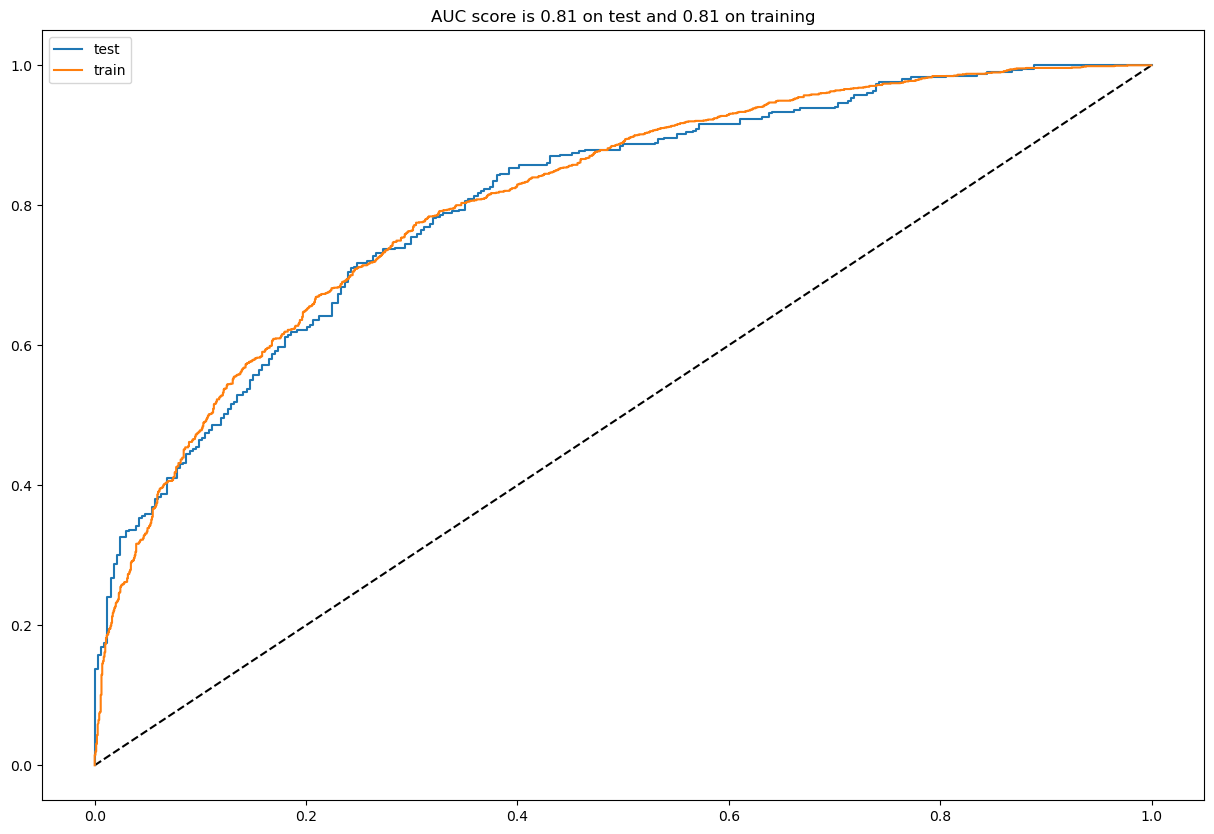

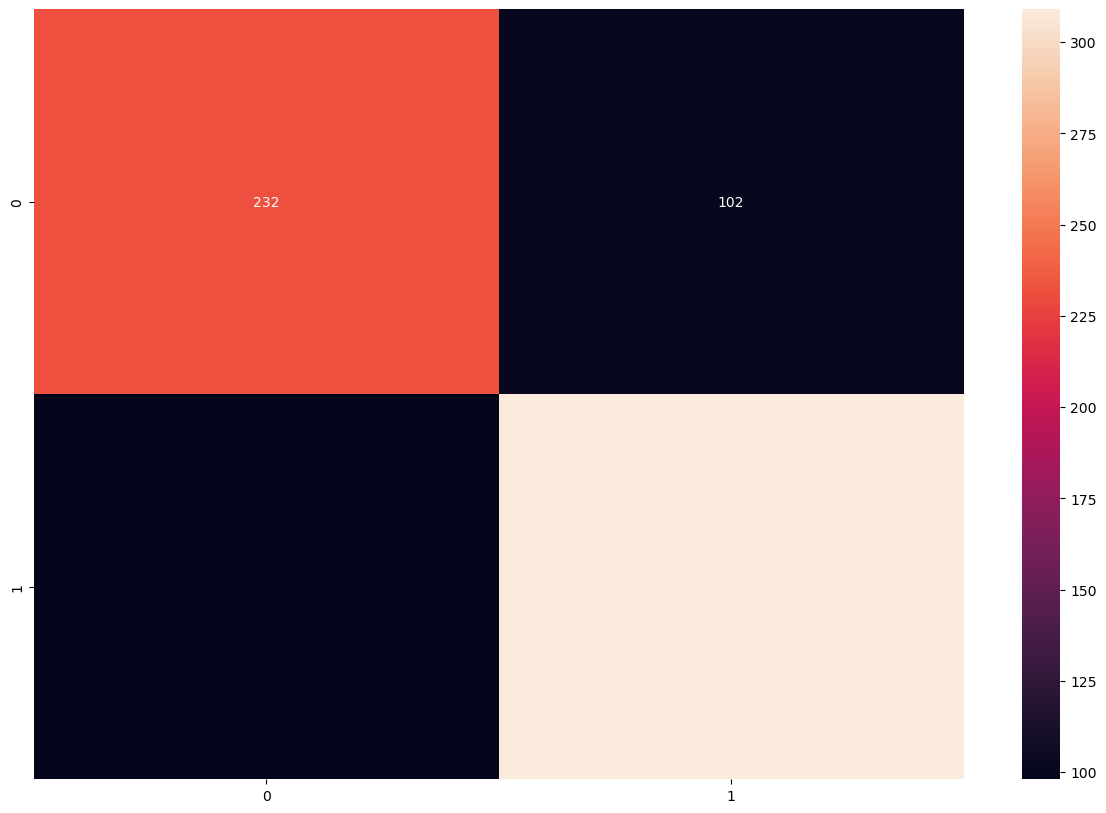

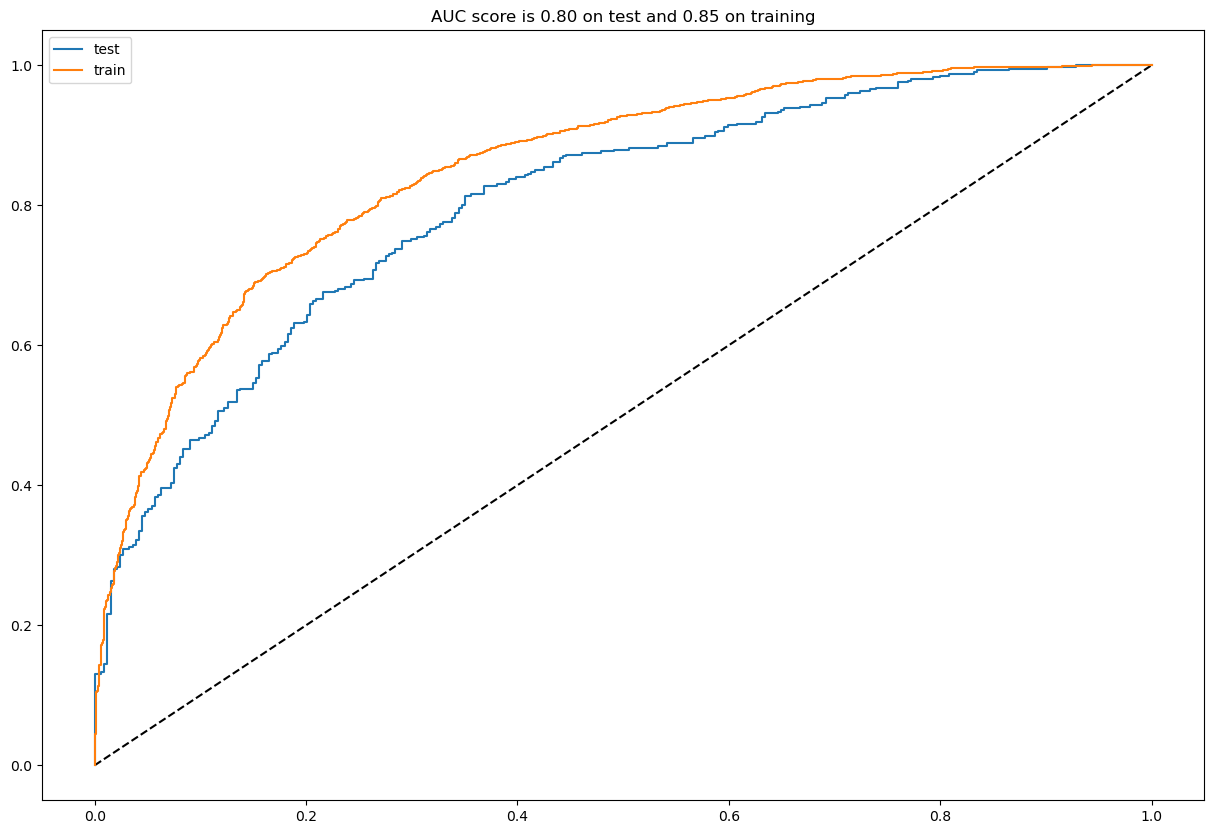

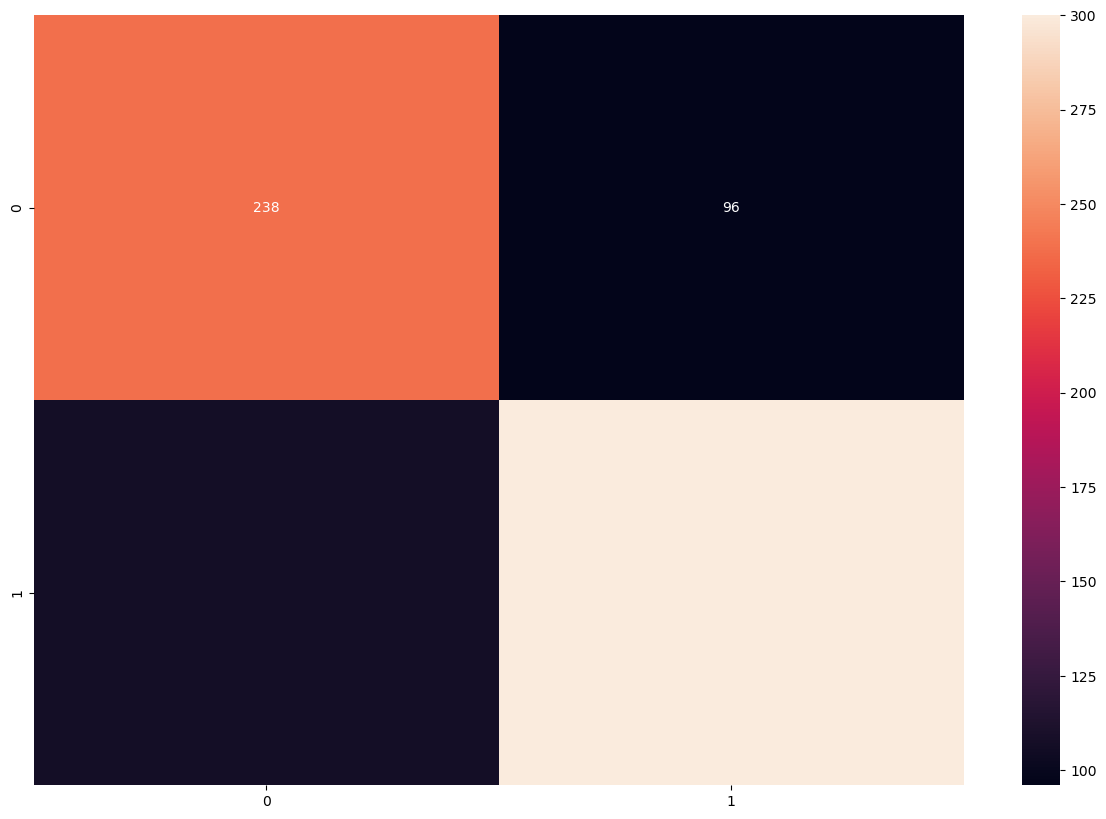

In [283]:
analyze(gb)
analyze(rf)

In [415]:
# Creating a Team Performance Table

team_list_EURO = {
    "Teams": ['Germany', 'Scotland', 'Hungary', 'Switzerland','Spain', 'Croatia', 'Italy', 'Albania', 
            'Slovenia', 'Denmark', 'Serbia', 'England', 'Poland', 'Netherlands', 'Austria', 'France',
            'Belgium', 'Slovakia', 'Romania', 'Ukraine', 'Turkey', 'Georgia', 'Portugal', 'Slovenia'],
    "Wins": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    "Draw": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    "Lose": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
}
df_team_list_EURO = pd.DataFrame(team_list_EURO)
df_team_list_EURO

,Teams,Wins,Draw,Lose
0,Germany,0,0,0
1,Scotland,0,0,0
2,Hungary,0,0,0
3,Switzerland,0,0,0
4,Spain,0,0,0
5,Croatia,0,0,0
6,Italy,0,0,0
7,Albania,0,0,0
8,Slovenia,0,0,0
9,Denmark,0,0,0


In [416]:
def update_win(team_name):
    if team_name in df_team_list_EURO['Teams'].values:
        df_team_list_EURO.loc[df_team_list_EURO['Teams'] == team_name, 'Wins'] += 1
    else:
        print(f"Team {team_name} not found.")

def update_draw(team_name):
    if team_name in df_team_list_EURO['Teams'].values:
        df_team_list_EURO.loc[df_team_list_EURO['Teams'] == team_name, 'Draw'] += 1
    else:
        print(f"Team {team_name} not found.")

def update_lose(team_name):
    if team_name in df_team_list_EURO['Teams'].values:
        df_team_list_EURO.loc[df_team_list_EURO['Teams'] == team_name, 'Lose'] += 1
    else:
        print(f"Team {team_name} not found.")

In [417]:
def create_table_with_points(teams):
    groups = ['A', 'B', 'C', 'D', 'E', 'F']
    table = {group: [[team, 0, []] for team in teams[group]] for group in groups}
    return table

teams = {
    'A': ['Germany', 'Scotland', 'Hungary', 'Switzerland'],
    'B': ['Spain', 'Croatia', 'Italy', 'Albania'],
    'C': ['Slovenia', 'Denmark', 'Serbia', 'England'],
    'D': ['Poland', 'Netherlands', 'Austria', 'France'],
    'E': ['Belgium', 'Slovakia', 'Romania', 'Ukraine'],
    'F': ['Turkey', 'Georgia', 'Portugal', 'Slovenia']
}

table = create_table_with_points(teams)
table

{'A': [['Germany', 0, []],
  ['Scotland', 0, []],
  ['Hungary', 0, []],
  ['Switzerland', 0, []]],
 'B': [['Spain', 0, []],
  ['Croatia', 0, []],
  ['Italy', 0, []],
  ['Albania', 0, []]],
 'C': [['Slovenia', 0, []],
  ['Denmark', 0, []],
  ['Serbia', 0, []],
  ['England', 0, []]],
 'D': [['Poland', 0, []],
  ['Netherlands', 0, []],
  ['Austria', 0, []],
  ['France', 0, []]],
 'E': [['Belgium', 0, []],
  ['Slovakia', 0, []],
  ['Romania', 0, []],
  ['Ukraine', 0, []]],
 'F': [['Turkey', 0, []],
  ['Georgia', 0, []],
  ['Portugal', 0, []],
  ['Slovenia', 0, []]]}

In [418]:
matches = []
for group, teams in table.items():
    for i in range(len(teams)):
        for j in range(i+1, len(teams)):
            matches.append((group, teams[i][0], teams[j][0]))

In [419]:
base_df = team_stats

In [420]:
def find_stats(team_1):
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf,
            team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [421]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, 
            dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0,0,0]


In [422]:
teams[0]

['Turkey', 0, []]

In [423]:
from operator import itemgetter

advanced_group = []
third_list = []
last_group = ""
thresh = 0.05

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []

for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])

    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1]) / 2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1]) / 2

    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | (
            (team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw = True
        update_draw(teams[1])
        update_draw(teams[2])
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1


    elif team_1_prob > team_2_prob:
        winner = teams[1]
        update_lose(teams[2])
        update_win(teams[1])
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3

    elif team_2_prob > team_1_prob:
        winner = teams[2]
        update_lose(teams[1])
        update_win(teams[2])
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3

    for i in table[teams[0]]:  
        if i[0] == teams[1]:
            i[2].append(team_1_prob)
        if i[0] == teams[2]:
            i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: " % (last_group))

            for i in table[last_group]:  
                i[2] = np.mean(i[2])

            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse=True)
            third_list.append(final_table[2][:2])
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d" % (i[0], i[1]))
        print("\n")
        print("-" * 10 + " Starting Analysis for Group %s " % (teams[0]) + "-" * 10)

    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability" % (teams[0], teams[1], teams[2], winner,
                                                                          winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw" % (teams[0], teams[1], teams[2]))
    last_group = teams[0]

print("\n")
print("Group %s advanced: " % (last_group))

for i in table[last_group]:  
    i[2] = np.mean(i[2])

final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse=True)
third_list.append(final_table[2][:2])
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d" % (i[0], i[1]))




---------- Starting Analysis for Group A ----------
Group A - Germany vs. Scotland: Winner Germany with 0.64 probability
Group A - Germany vs. Hungary: Winner Germany with 0.60 probability
Group A - Germany vs. Switzerland: Winner Germany with 0.57 probability
Group A - Scotland vs. Hungary: Winner Hungary with 0.58 probability
Group A - Scotland vs. Switzerland: Winner Switzerland with 0.62 probability
Group A - Hungary vs. Switzerland: Draw


Group A advanced: 
Germany -------- 9
Switzerland -------- 4
Hungary -------- 4
Scotland -------- 0


---------- Starting Analysis for Group B ----------
Group B - Spain vs. Croatia: Draw
Group B - Spain vs. Italy: Draw
Group B - Spain vs. Albania: Winner Spain with 0.69 probability
Group B - Croatia vs. Italy: Draw
Group B - Croatia vs. Albania: Winner Croatia with 0.67 probability
Group B - Italy vs. Albania: Winner Italy with 0.69 probability


Group B advanced: 
Spain -------- 5
Italy -------- 5
Croatia -------- 5
Albania -------- 0


----

In [424]:
df_team_list_EURO

,Teams,Wins,Draw,Lose
0,Germany,3,0,0
1,Scotland,0,0,3
2,Hungary,1,1,1
3,Switzerland,1,1,1
4,Spain,1,2,0
5,Croatia,1,2,0
6,Italy,1,2,0
7,Albania,0,0,3
8,Slovenia,1,0,5
9,Denmark,1,1,1


In [425]:
third_list
sorted_third_list = sorted(third_list, key=lambda x: x[1], reverse=True)
t_list = [item[0] for item in sorted_third_list]

t_list

['Croatia', 'Hungary', 'Serbia', 'Slovenia', 'Austria', 'Romania']

In [426]:
advanced = advanced_group
advanced.append([t_list[0], t_list[2]])
advanced.append([t_list[1], t_list[3]])
advanced

[['Germany', 'Switzerland'],
 ['Spain', 'Italy'],
 ['England', 'Denmark'],
 ['France', 'Netherlands'],
 ['Belgium', 'Ukraine'],
 ['Portugal', 'Turkey'],
 ['Croatia', 'Serbia'],
 ['Hungary', 'Slovenia']]

In [427]:
# playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}
# playoffs

In [428]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []


for p in playoffs.keys():
    if p == "Round of 16":
        playoffs[p] = [[advanced[c][0], advanced[c][1]] for c in range(len(advanced))]
        
        for i in range(len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)

            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])

            team_1_prob = (probs_g1[0][0] + probs_g2[0][1]) / 2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1]) / 2

            if actual_round != p:
                print("-" * 10)
                print("Starting simulation of %s" % (p))
                print("-" * 10)
                print("\n")

            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f" % (home, away, away, team_2_prob))
                update_win(away)
                update_lose(home)
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f" % (home, away, home, team_1_prob))
                update_win(home)
                update_lose(away)
                next_rounds.append(home)

            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p

    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c + 1]] for c in range(0, len(next_rounds) - 1, 2)]
        next_rounds = []
        for i in range(len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)

            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])

            team_1_prob = (probs_g1[0][0] + probs_g2[0][1]) / 2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1]) / 2

            if actual_round != p:
                print("-" * 10)
                print("Starting simulation of %s" % (p))
                print("-" * 10)
                print("\n")

            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f" % (home, away, away, team_2_prob))
                update_win(away)
                update_lose(home)
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f" % (home, away, home, team_1_prob))
                update_win(home)
                update_lose(away)
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p


----------
Starting simulation of Round of 16
----------


Germany vs. Switzerland: Germany advances with prob 0.57
Spain vs. Italy: Spain advances with prob 0.53
England vs. Denmark: England advances with prob 0.61
France vs. Netherlands: France advances with prob 0.54
Belgium vs. Ukraine: Belgium advances with prob 0.63
Portugal vs. Turkey: Portugal advances with prob 0.66
Croatia vs. Serbia: Croatia advances with prob 0.61
Hungary vs. Slovenia: Hungary advances with prob 0.59
----------
Starting simulation of Quarter-Final
----------


Germany vs. Spain: Germany advances with prob 0.53
England vs. France: England advances with prob 0.51
Belgium vs. Portugal: Belgium advances with prob 0.51
Croatia vs. Hungary: Croatia advances with prob 0.59
----------
Starting simulation of Semi-Final
----------


Germany vs. England: England advances with prob 0.53
Belgium vs. Croatia: Belgium advances with prob 0.57
----------
Starting simulation of Final
----------


England vs. Belgium: England

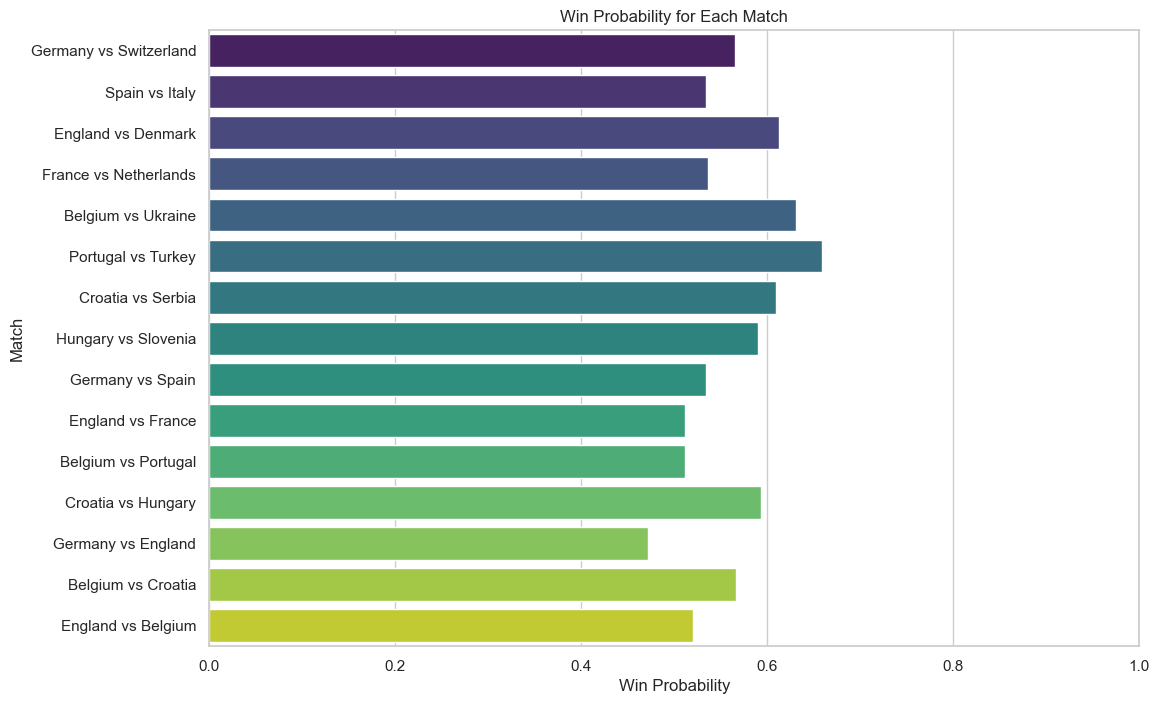

In [429]:
data = playoffs.copy()

matches = []
teams = []
probs = []

for round_name, match_list in data.items():
    for match in match_list:
        teams.append(f"{match[0]} vs {match[1]}")
        probs.append(match[2][0])  # Using team 1 win probability for simplicity

matches_df = pd.DataFrame({'Match': teams, 'Win Probability': probs})

# Plotting using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Win Probability', y='Match', data=matches_df, palette='viridis')
plt.title('Win Probability for Each Match')
plt.xlabel('Win Probability')
plt.ylabel('Match')
plt.xlim(0, 1)  # Limit the x-axis from 0 to 1
plt.show()

In [367]:
df_team_list_EURO = df_team_list_EURO.sort_values(by="Wins", ascending=False)
df_team_list_EURO['Matches_Played'] = df_team_list_EURO['Wins'] + df_team_list_EURO['Draw'] + df_team_list_EURO['Lose']
df_team_list_EURO['Win_%'] = df_team_list_EURO['Wins'] / df_team_list_EURO['Matches_Played']

df_team_list_EURO

,Teams,Wins,Draw,Lose,Matches_Played,Win_%
11,England,7,0,0,7,1.000000
16,Belgium,6,0,1,7,0.857143
0,Germany,5,0,1,6,0.833333
22,Portugal,4,0,1,5,0.800000
5,Croatia,3,2,1,6,0.500000
15,France,3,1,1,5,0.600000
2,Hungary,2,1,2,5,0.400000
4,Spain,2,2,1,5,0.400000
20,Turkey,2,0,2,4,0.500000
19,Ukraine,2,0,2,4,0.500000


In [368]:
df_team_list_EURO.columns

Index(['Teams', 'Wins', 'Draw', 'Lose', 'Matches_Played', 'Win_%'], dtype='object')

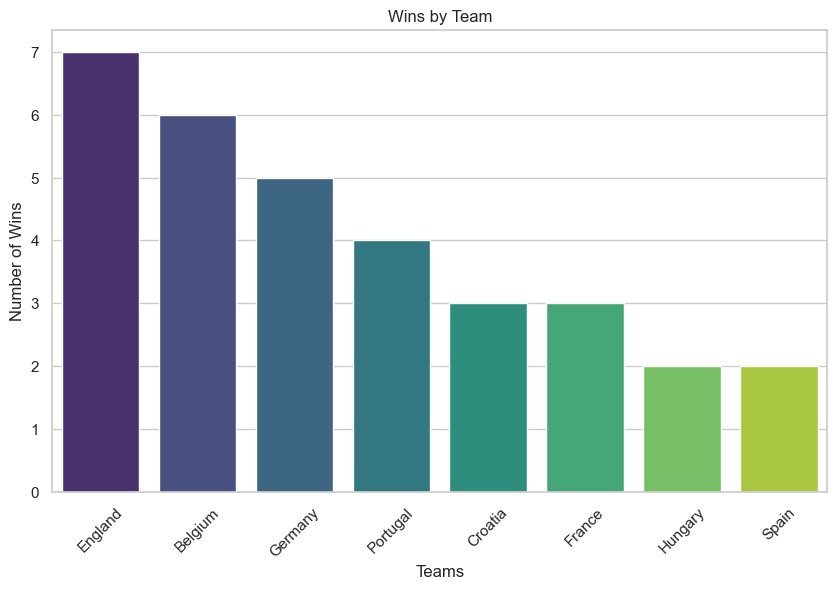

In [371]:
# Set the visual style
df = df_team_list_EURO.copy()
df = df.head(8)
sns.set(style="whitegrid")

# Bar plot of Wins
plt.figure(figsize=(10, 6))
sns.barplot(x="Teams", y="Wins", data=df, palette="viridis")
plt.title("Wins by Team")
plt.xlabel("Teams")
plt.ylabel("Number of Wins")
plt.xticks(rotation=45)
plt.show()

# # Bar plot of Win Percentage
# plt.figure(figsize=(10, 6))
# sns.barplot(x="Teams", y="Win_%", data=df, palette="coolwarm")
# plt.title("Win Percentage by Team")
# plt.xlabel("Teams")
# plt.ylabel("Win Percentage")
# plt.xticks(rotation=45)
# plt.show()

# # Heatmap of the full DataFrame
# plt.figure(figsize=(12, 8))
# sns.heatmap(df.set_index('Teams').T, annot=True, cmap="YlGnBu", cbar=False)
# plt.title("Heatmap of Teams Data")
# plt.xlabel("Teams")
# plt.ylabel("Metrics")
# plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


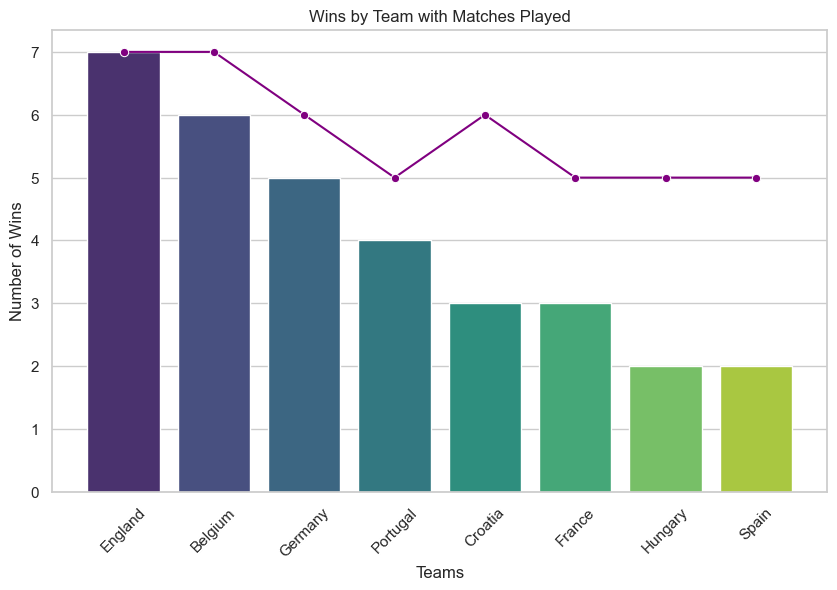

In [381]:
# Create a bar plot with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot of Wins
sns.barplot(x="Teams", y="Wins", data=df, palette="viridis", ax=ax1)
ax1.set_title("Wins by Team with Matches Played")
ax1.set_xlabel("Teams")
ax1.set_ylabel("Number of Wins")
ax1.tick_params(axis='x', rotation=45)

# Create a secondary y-axis
# ax2 = ax1.twinx()
sns.lineplot(x="Teams", y="Matches_Played", data=df, color='purple', marker='o', ax=ax1)
ax2.set_ylabel("Matches Played")

# Show the plot
plt.show()

In [445]:
# Print Quarter-Final
print("==== Quarter-Final ====")
for match in tournament_data['Quarter-Final']:
    print(f"{match[0]} vs. {match[1]}")

print("")
# Print Semi-Final
print("==== Semi-Final ====")
for match in tournament_data['Semi-Final']:
    print(f"{match[0]} vs. {match[1]}")

print("")
# Print Final
print("==== Final ====")
for match in tournament_data['Final']:
    print(f"{match[0]} vs. {match[1]}")

print("")
# Print EURO 2024 Winner
print("==== EURO 2024 Winner ====")
for match in tournament_data['Final']:
    print(f"{match[0]}")

==== Quarter-Final ====
Germany vs. Spain
England vs. France
Belgium vs. Portugal
Croatia vs. Hungary

==== Semi-Final ====
Germany vs. England
Belgium vs. Croatia

==== Final ====
England vs. Belgium

==== EURO 2024 Winner ====
England
